In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import glob
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D,AveragePooling2D, Flatten, Dropout 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# hyperparameter setting
image_size = 256
batch_size = 32
epochs = 5

In [4]:
# input files

base_dir='/content/gdrive/My Drive/DATASET/input/Train'

lable_list = os.listdir(base_dir)

dataset = []

for i in range(len(lable_list)):
  path = base_dir + '/' + lable_list[i]
  dataset.append(glob.glob(path + '/*'))
  print(f'{lable_list[i]} : {len(dataset[i])}')

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 3284
Corn_(maize)___Common_rust_ : 3814
Corn_(maize)___healthy : 3728
Grape___healthy : 3404
Grape___Black_rot : 3776
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) : 3240
Corn_(maize)___Northern_Leaf_Blight : 3816
Grape___Esca_(Black_Measles) : 3840
Potato___Late_blight : 3878
Potato___healthy : 3648
Tomato___Bacterial_spot : 3404
Tomato___Early_blight : 3840
Tomato___healthy : 3852
Tomato___Late_blight : 3702
Pepper,_bell___Bacterial_spot : 3826
Pepper,_bell___healthy : 3976
Potato___Early_blight : 3878


In [5]:
# add labels

def add_labels(data, label):
    return list(map(lambda x: (x, label), data))

dataset_label = []

for i in range(len(lable_list)):
  files = add_labels(dataset[i], lable_list[i])
  dataset_label.append(files)
  print(dataset_label[i][0])

('/content/gdrive/My Drive/DATASET/input/Train/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/4f50bad3-aee2-4d6d-a144-5c56f4c1fdd9___RS_GLSp 9297_new30degFlipLR(1).JPG', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot')
('/content/gdrive/My Drive/DATASET/input/Train/Corn_(maize)___Common_rust_/RS_Rust 2025(1).JPG', 'Corn_(maize)___Common_rust_')
('/content/gdrive/My Drive/DATASET/input/Train/Corn_(maize)___healthy/0761360f-9118-4019-a513-e0b80d871a3d___R.S_HL 8175 copy(1).jpg', 'Corn_(maize)___healthy')
('/content/gdrive/My Drive/DATASET/input/Train/Grape___healthy/81c43511-4903-46db-9022-38c756418f34___Mt.N.V_HL 9124(1).JPG', 'Grape___healthy')
('/content/gdrive/My Drive/DATASET/input/Train/Grape___Black_rot/d01f7d62-fa36-499d-9876-914ae1a8827a___FAM_B.Rot 0475(1).JPG', 'Grape___Black_rot')
('/content/gdrive/My Drive/DATASET/input/Train/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/290fc735-ee93-4ce3-83cf-a04670ddb6b0___FAM_L.Blight 4563(1).JPG', 'Grape___Leaf_blight_(Isariopsis_

In [6]:
# split the data
def split_data(data):
    train_data, test_data = train_test_split(data, test_size=0.15)
    train_data, val_data = train_test_split(train_data, test_size=0.15)
    return [train_data, val_data, test_data]

dataset_data = []

for i in range(len(lable_list)):
  data = split_data(dataset_label[i])
  dataset_data.append(data)

In [7]:
# collect data
train_data = []
val_data = []
test_data = []

def collect(data):
    global train_data, val_data, test_data
    for sample in data[0]:
        train_data.append(sample)
    
    for sample in data[1]:
        val_data.append(sample)
        
    for sample in data[2]:
        test_data.append(sample)

for i in range(len(lable_list)):
  collect(dataset_data[i])
    
# convert them into dataframes
train_df = pd.DataFrame(train_data, columns=['image', 'label'])
val_df = pd.DataFrame(val_data, columns=['image', 'label'])
test_df = pd.DataFrame(test_data, columns=['image', 'label'])

print(len(train_df), len(val_df), len(test_df))

45436 8027 9443


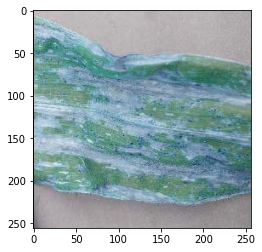

In [8]:
plt.figure()
image = cv2.imread(train_df['image'][0])
plt.imshow(image)

In [9]:
# data augmentation (train)

train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=10,
                               zoom_range = 0.1,
                               shear_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True)

train_set = train_gen.flow_from_dataframe(dataframe=train_df,
                                          x_col='image',
                                          y_col='label',
                                          target_size=(image_size, image_size),
                                          batch_size=batch_size,
                                          shuffle=True,
                                          class_mode='categorical',
                                          color_mode='grayscale')

# rescaling (validation)
val_rescaled = ImageDataGenerator(rescale = 1./255)

val_set = val_rescaled.flow_from_dataframe(dataframe=val_df,
                                           x_col='image',
                                           y_col='label',
                                           target_size=(image_size, image_size),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           class_mode='categorical',
                                           color_mode='grayscale')

# rescaling (test)
test_rescaled = ImageDataGenerator(rescale = 1./255)

test_set = test_rescaled.flow_from_dataframe(dataframe=test_df,
                                             x_col='image',
                                             y_col='label',
                                             target_size=(image_size, image_size),
                                             batch_size=1,
                                             shuffle=False,
                                             class_mode='categorical',
                                             color_mode='grayscale')

Found 45436 validated image filenames belonging to 17 classes.
Found 8027 validated image filenames belonging to 17 classes.
Found 9443 validated image filenames belonging to 17 classes.


In [10]:
# build the model

# pretrained_model = MobileNet(input_shape=(image_size, image_size, 3),
#                          include_top=False,
#                          weights='imagenet')

model = Sequential([
    Conv2D(filters = 32, kernel_size = (5,5), padding = 'same', 
           activation ='relu', input_shape = (image_size, image_size, 1)),
    AveragePooling2D(pool_size=(2,2)),
    
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation ='relu'),
    AveragePooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation ='relu'),
    AveragePooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation ='relu'),
    AveragePooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.4),
    Dense(len(lable_list), activation='softmax')
])

# model.layers[0].trainable = False

In [11]:
# model configuration
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', 
                   patience=8, 
                   restore_best_weights=True)

# lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
#                                  patience = 4, 
#                                  verbose=1,
#                                  factor=0.5, 
#                                  min_lr=0.00005)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      832       
_________________________________________________________________
average_pooling2d (AveragePo (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
average_pooling2d_2 (Average (None, 32, 32, 128)       0

In [ ]:
history = model.fit_generator(train_set,
                              steps_per_epoch=len(train_set),
                              epochs=epochs,
                              validation_data=val_set,
                              validation_steps=len(val_set),
                              callbacks=[es]) 

Epoch 1/5
 258/1420 [====>.........................] - ETA: 4:51:55 - loss: 2.5793 - accuracy: 0.1749

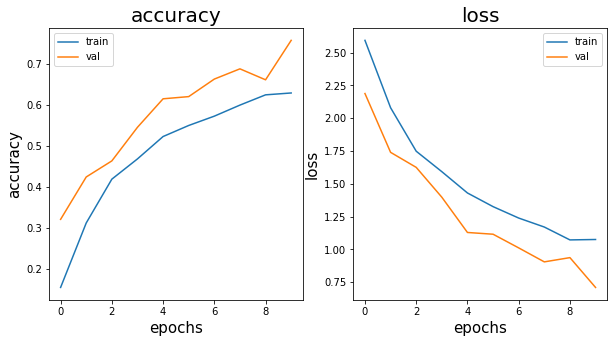

In [ ]:
# plot the accuracy and loss of the model
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, e in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[e])
    ax[i].plot(history.history['val_' + e])
    ax[i].set_title(e, fontsize=20)
    ax[i].set_xlabel('epochs', fontsize=15)
    ax[i].set_ylabel(e, fontsize=15)
    ax[i].legend(['train', 'val'])

0 : Corn_(maize)___healthy
1 : Grape___Black_rot
2 : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
3 : Grape___healthy
4 : Pepper,_bell___healthy
5 : Corn_(maize)___Common_rust_
6 : Corn_(maize)___Northern_Leaf_Blight
7 : Pepper,_bell___Bacterial_spot
8 : Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
9 : Grape___Esca_(Black_Measles)
10 : Tomato___Bacterial_spot
11 : Potato___healthy
12 : Potato___Late_blight
13 : Tomato___Late_blight
14 : Tomato___Early_blight
15 : Potato___Early_blight
16 : Tomato___healthy


(<Figure size 1224x1224 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f69d70e9890>)

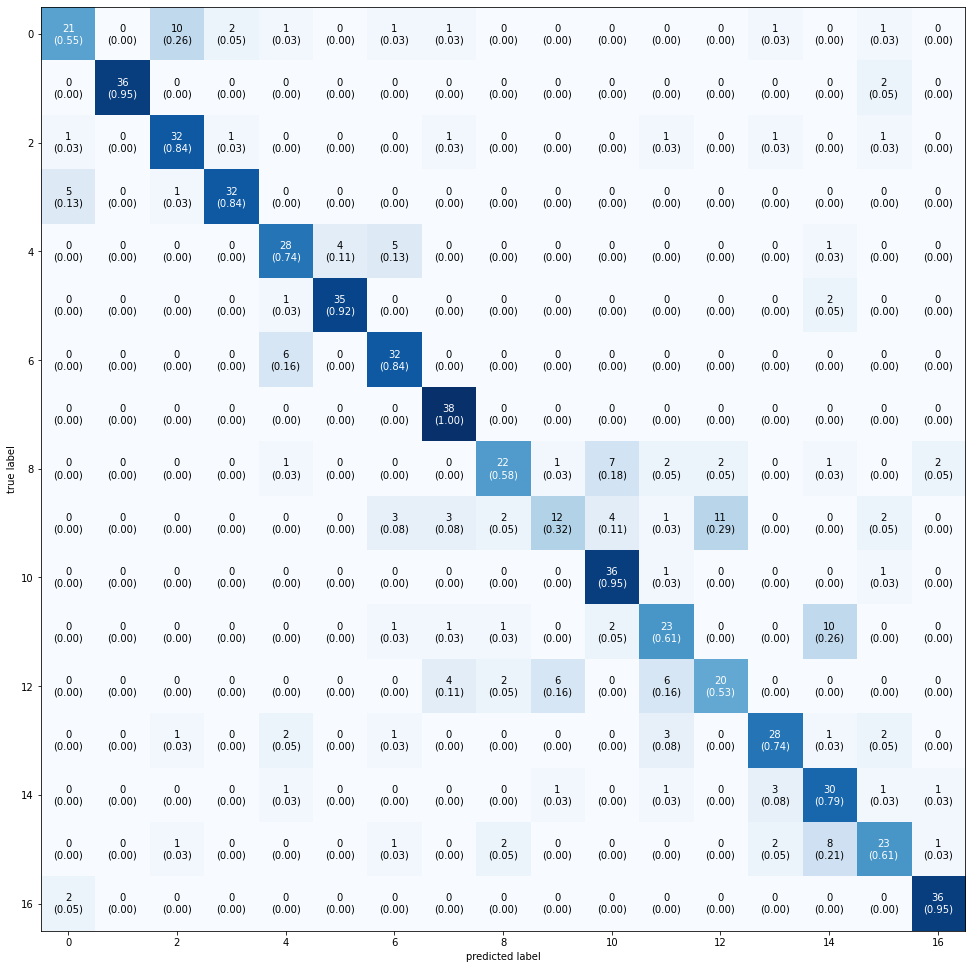

In [ ]:
# test the model

for i in range(len(lable_list)):
  print(f"{i} : {lable_list[i]}")

predictions = model.predict_classes(test_set)

cm = confusion_matrix(test_set.classes, predictions)
plot_confusion_matrix(conf_mat = cm, 
                      figsize=(17,17),
                      show_normed=True)

In [ ]:
test_accuracy = (cm[0, 0] + cm[1, 1] + cm[2,2] + cm[3,3]) / len(test_set)
print("Test Accuracy: {}%".format(round(test_accuracy * 100, 3)))

Test Accuracy: 18.731%
